<a href="https://colab.research.google.com/github/o-Erebus/IMDB-Sentiment-Analysis-ML-vs-DL/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cell 1: Imports and Setup (MODIFIED)
# -*- coding: utf-8 -*-
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
# Import other potential sklearn models if needed
# from sklearn.svm import LinearSVC
# from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import time # To time processes

# Keras / TensorFlow imports for DL model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping

# Ensure necessary NLTK data is downloaded
try:
    stopwords.words('english')
except LookupError:
    print("NLTK 'stopwords' corpus not found. Downloading...")
    nltk.download('stopwords')
    print("Download complete.")
print("Ensured NLTK stopwords are available.")

# Print versions
print("TensorFlow Version:", tf.__version__)
print("NumPy Version:", np.__version__)
print("Pandas Version:", pd.__version__)

# Global settings
RANDOM_STATE = 42
IS_DEEP_LEARNING_MODEL = False # Flag to control workflow

# Check for GPU
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    print(f"TensorFlow detected {len(gpu_devices)} GPU(s): {gpu_devices}")
    tf.config.experimental.set_memory_growth(gpu_devices[0], True) # Avoid allocating all GPU memory at once
else:
    print("TensorFlow did not detect any GPUs. Training the DL model will use CPU and may be slow.")

Ensured NLTK stopwords are available.
TensorFlow Version: 2.18.0
NumPy Version: 2.0.2
Pandas Version: 2.2.2
TensorFlow detected 1 GPU(s): [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Cell 2: Load Data (IMDb using TensorFlow Datasets)
# (Keep this cell as it was)
print("Loading IMDb dataset...")
ds, info = tfds.load('imdb_reviews', split=['train', 'test'], as_supervised=True, with_info=True)
ds_train_raw, ds_test_raw = ds
print("Dataset loaded.")
print("\nDataset Info:")
print(info)

Loading IMDb dataset...


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.E7YE5C_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.E7YE5C_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.E7YE5C_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
Dataset loaded.

Dataset Info:
tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset. This is a dataset for binary sentiment
    classification containing substantially more data than previous benchmark
    datasets. We provide a set of 25,000 highly polar movie reviews for training,
    and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_dir='/root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0',
    file_format=tfrecord,
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
        'text': Text(shape

In [ ]:
# Cell 3: Extract Data and Initial Inspection
# (Keep this cell as it was)
print("Extracting data into lists...")
start_time = time.time()
train_texts = []
train_labels = []
test_texts = []
test_labels = []
for text_tensor, label_tensor in tfds.as_numpy(ds_train_raw):
    train_texts.append(text_tensor.decode('utf-8'))
    train_labels.append(label_tensor)
for text_tensor, label_tensor in tfds.as_numpy(ds_test_raw):
    test_texts.append(text_tensor.decode('utf-8'))
    test_labels.append(label_tensor)

train_texts = np.array(train_texts)
train_labels = np.array(train_labels).astype(np.int32) # Ensure labels are integers
test_texts = np.array(test_texts)
test_labels = np.array(test_labels).astype(np.int32) # Ensure labels are integers
end_time = time.time()
print(f"Data extraction finished in {end_time - start_time:.2f} seconds.")
print(f"\nNumber of training samples: {len(train_texts)}")
print(f"Number of test samples: {len(test_texts)}")
print(f"Label distribution in training data: {np.bincount(train_labels)}")
print(f"Label distribution in test data: {np.bincount(test_labels)}")
print("\nSample review (Raw):")
print(f"Text: {train_texts[0][:250]}...")
print(f"Label: {'Positive' if train_labels[0] == 1 else 'Negative'} ({train_labels[0]})")

Extracting data into lists...
Data extraction finished in 32.39 seconds.

Number of training samples: 25000
Number of test samples: 25000
Label distribution in training data: [12500 12500]
Label distribution in test data: [12500 12500]

Sample review (Raw):
Text: This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline...
Label: Negative (0)


In [ ]:
# Cell 4: Define Text Preprocessing Function
# (Keep this cell as it was, but note stopword removal impact)
print("Defining text preprocessing function...")
stop_words = set(stopwords.words('english'))
def preprocess_text(text):
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text) # Keep only letters and spaces
    text = text.lower()
    words = text.split()
    # Note: For some DL models, removing stopwords isn't always best,
    # but we keep it here for consistency with the original request.
    words = [word for word in words if word.isalpha() and word not in stop_words]
    text = ' '.join(words)
    return text
print("Preprocessing function defined.")
sample_processed = preprocess_text(train_texts[0])
print("\nSample preprocessing test:")
print(f"Original:  {train_texts[0][:250]}...")
print(f"Processed: {sample_processed[:250]}...")

Defining text preprocessing function...
Preprocessing function defined.

Sample preprocessing test:
Original:  This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline...
Processed: absolutely terrible movie dont lured christopher walken michael ironside great actors must simply worst role history even great acting could redeem movies ridiculous storyline movie early nineties us propaganda piece pathetic scenes columbian rebels ...


In [ ]:
# Cell 5: Apply Preprocessing to Datasets
# (Keep this cell as it was)
print("Starting text preprocessing on train and test sets...")
print("(This may take a few minutes)")
start_time = time.time()
train_texts_processed = [preprocess_text(text) for text in train_texts]
test_texts_processed = [preprocess_text(text) for text in test_texts]
end_time = time.time()
print(f"Preprocessing finished in {end_time - start_time:.2f} seconds.")
print("\nSample processed review (from dataset):")
print(f"Processed: {train_texts_processed[0][:250]}...")
print(f"Original length: {len(train_texts[0])}, Processed length: {len(train_texts_processed[0])}")

Starting text preprocessing on train and test sets...
(This may take a few minutes)
Preprocessing finished in 5.06 seconds.

Sample processed review (from dataset):
Processed: absolutely terrible movie dont lured christopher walken michael ironside great actors must simply worst role history even great acting could redeem movies ridiculous storyline movie early nineties us propaganda piece pathetic scenes columbian rebels ...
Original length: 709, Processed length: 486


In [ ]:
# Cell 6: Split Data into Training and Validation Sets
# (Keep this cell as it was)
print("Splitting the original training data into Training and Validation sets...")
X = train_texts_processed
y = train_labels
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
X_test = test_texts_processed
y_test = test_labels
print(f"Training set size:   {len(X_train)} samples")
print(f"Validation set size: {len(X_val)} samples")
print(f"Test set size:       {len(X_test)} samples")
print(f"Label distribution in y_train: {np.bincount(y_train)}")
print(f"Label distribution in y_val:   {np.bincount(y_val)}")

Splitting the original training data into Training and Validation sets...
Training set size:   20000 samples
Validation set size: 5000 samples
Test set size:       25000 samples
Label distribution in y_train: [10000 10000]
Label distribution in y_val:   [2500 2500]


In [ ]:
# Cell 7: Feature Engineering (Conditional: TF-IDF or Skip for DL)
# (MODIFIED - Now conditional)

print("\n--- Feature Engineering / Data Preparation ---")

# Defined later based on model choice
X_train_features = None
X_val_features = None
X_test_features = None
tfidf_vectorizer = None # Will be defined only if TF-IDF is used

# --- Placeholder: Specific preparation happens after model choice ---
print("Feature engineering step. Specific method (TF-IDF or Tokenization/Padding) depends on model choice.")


--- Feature Engineering / Data Preparation ---
Feature engineering step. Specific method (TF-IDF or Tokenization/Padding) depends on model choice.


In [ ]:
# Cell 8: Model Selection and Hyperparameter Grid Definition (MODIFIED)
print("\n--- Model Selection ---")

# --- Choose ONE option by uncommenting the desired block ---

# === Option 1: Logistic Regression ===
# MODEL_NAME = "Logistic Regression"
# IS_DEEP_LEARNING_MODEL = False
# model_= LogisticRegression(solver='saga', max_iter=1000, random_state=RANDOM_STATE, n_jobs=-1)
# param_grid = {'C': [0.1, 1, 10, 100]}

# === Option 2: Linear SVM ===
# from sklearn.svm import LinearSVC
# MODEL_NAME = "Linear SVM"
# IS_DEEP_LEARNING_MODEL = False
# model_ = LinearSVC(max_iter=2000, random_state=RANDOM_STATE, dual='auto') # dual='auto' is safer
# param_grid = {'C': [0.1, 1, 10]}

# === Option 3: Multinomial Naive Bayes ===
# from sklearn.naive_bayes import MultinomialNB
# MODEL_NAME = "Multinomial Naive Bayes"
# IS_DEEP_LEARNING_MODEL = False
# model_ = MultinomialNB()
# param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0]}

# # === Option 4: CNN + BiLSTM ===
MODEL_NAME = "CNN + BiLSTM"
IS_DEEP_LEARNING_MODEL = True
model_ = None # Keras model defined later
param_grid = None # No grid search for Keras model in this setup

# --- End of model selection ---

if model_ is None and not IS_DEEP_LEARNING_MODEL:
     raise ValueError("Please uncomment one of the scikit-learn model options in Cell 8.")
if IS_DEEP_LEARNING_MODEL and param_grid is not None:
     print("Warning: param_grid is set but IS_DEEP_LEARNING_MODEL is True. GridSearchCV will not be used.")

print(f"\nSelected model type: {MODEL_NAME}")
if not IS_DEEP_LEARNING_MODEL:
    print(f"Parameter grid for GridSearchCV: {param_grid}")
else:
    print("Using Keras deep learning model. Architecture defined separately.")


--- Model Selection ---

Selected model type: CNN + BiLSTM
Using Keras deep learning model. Architecture defined separately.


In [ ]:
# Cell 7b: Tokenization and Padding (Runs ONLY for DL Model) (NEW)

if IS_DEEP_LEARNING_MODEL:
    print("\n--- Tokenization and Padding for Deep Learning Model ---")
    start_time = time.time()

    # Define Tokenizer parameters
    VOCAB_SIZE = 20000  # Max number of words to keep
    MAX_SEQUENCE_LENGTH = 250 # Max length of sequences (pad/truncate)
    EMBEDDING_DIM = 128 # Dimension of word embeddings

    # Initialize and fit tokenizer
    print(f"Initializing Tokenizer (vocab_size={VOCAB_SIZE})...")
    tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>') # OOV for out-of-vocabulary words
    tokenizer.fit_on_texts(X_train)
    word_index = tokenizer.word_index
    print(f"Found {len(word_index)} unique tokens. Using top {VOCAB_SIZE}.")

    # Convert texts to sequences
    print("Converting texts to sequences...")
    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_val_seq = tokenizer.texts_to_sequences(X_val)
    X_test_seq = tokenizer.texts_to_sequences(X_test)

    # Pad sequences
    print(f"Padding sequences to max length {MAX_SEQUENCE_LENGTH}...")
    X_train_features = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
    X_val_features = pad_sequences(X_val_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
    X_test_features = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

    end_time = time.time()
    print(f"Tokenization and padding finished in {end_time - start_time:.2f} seconds.")
    print("\nShape of padded sequence tensors:")
    print(f"Train:      {X_train_features.shape}")
    print(f"Validation: {X_val_features.shape}")
    print(f"Test:       {X_test_features.shape}")
    print("\nSample padded sequence (first review):")
    print(X_train_features[0][:50], "...") # Show first 50 indices

else:
    # --- Apply TF-IDF for scikit-learn models ---
    print("\n--- Applying TF-IDF Vectorization for Scikit-learn Model ---")
    start_time = time.time()
    tfidf_vectorizer = TfidfVectorizer(
        max_features=25000,
        ngram_range=(1, 2),
        min_df=3,
        max_df=0.9
    )
    print("Fitting TF-IDF on training data...")
    tfidf_vectorizer.fit(X_train)
    print("Transforming datasets...")
    X_train_features = tfidf_vectorizer.transform(X_train)
    X_val_features = tfidf_vectorizer.transform(X_val)
    X_test_features = tfidf_vectorizer.transform(X_test)
    end_time = time.time()
    print(f"TF-IDF finished in {end_time - start_time:.2f} seconds.")
    print(f"\nShape of TF-IDF matrices:")
    print(f"Train:      {X_train_features.shape}")
    print(f"Validation: {X_val_features.shape}")
    print(f"Test:       {X_test_features.shape}")


--- Tokenization and Padding for Deep Learning Model ---
Initializing Tokenizer (vocab_size=20000)...
Found 96565 unique tokens. Using top 20000.
Converting texts to sequences...
Padding sequences to max length 250...
Tokenization and padding finished in 5.73 seconds.

Shape of padded sequence tensors:
Train:      (20000, 250)
Validation: (5000, 250)
Test:       (25000, 250)

Sample padded sequence (first review):
[ 2297     3  1798    79     1 17849  1886   355   463   447  6339   630
  2852  1674  1854  3095    90  1311   236   641  4321  7329   687  1510
  1478 10605   602  7329  2061  1279 12116   540  2582   272   213  1403
  5698  1284  1623  1641     1 17849  1830   948  4870     1  4871   192
  2081   455] ...


In [ ]:
# Cell 8b: Define Keras Model Architecture (Runs ONLY for DL Model) (NEW)

if IS_DEEP_LEARNING_MODEL:
    print(f"\n--- Defining Keras {MODEL_NAME} Model Architecture ---")

    # Clear previous Keras session (good practice)
    tf.keras.backend.clear_session()

    model = Sequential([
        # 1. Embedding Layer
        Embedding(input_dim=VOCAB_SIZE, # Size of the vocabulary
                  output_dim=EMBEDDING_DIM, # Dimension of the dense embedding
                  input_length=MAX_SEQUENCE_LENGTH, # Length of input sequences
                  name="embedding"),

        # 2. Convolutional Layer
        Conv1D(filters=64, kernel_size=5, activation='relu', name="conv1d"),

        # 3. Max Pooling Layer
        MaxPooling1D(pool_size=4, name="maxpool1d"),
         Dropout(0.5, name="dropout1"), # Dropout for regularization
        # 2. Convolutional Layer
        Conv1D(filters=128, kernel_size=5, activation='relu', name="conv1d2"),
        # 3. Max Pooling Layer
        MaxPooling1D(pool_size=4, name="maxpool1d2"),
         Dropout(0.5, name="dropout2"), # Dropout for regularization

        # 4. Bidirectional LSTM Layer
        Bidirectional(LSTM(units=64, return_sequences=False), name="bidirectional_lstm"), # return_sequences=False because the next layer is Dense
        Dropout(0.5, name="dropout3"), # Dropout for regularization
        # Using GlobalMaxPooling1D after LSTM can sometimes work well too instead of return_sequences=False
        # GlobalMaxPooling1D(), # Alternative pooling strategy after LSTM

        # 5. Dense Hidden Layer (Optional but common)
        Dense(units=64, activation='relu', name="dense_hidden"),
        Dropout(0.5, name="dropout4"), # Dropout for regularization
        Dense(units=32, activation='relu', name="dense_hidden2"),
        Dense(units=32, activation='relu', name="dense_hidden3"),
        Dropout(0.5, name="dropout5"), # Dropout for regularization

        # 6. Output Layer
        Dense(units=1, activation='sigmoid', name="output") # Sigmoid for binary classification
    ])

    # Compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    print("Model compiled.")
    model.summary() # Print model architecture details

else:
    print(f"\nSkipping Keras model definition (using {MODEL_NAME}).")


--- Defining Keras CNN + BiLSTM Model Architecture ---
Model compiled.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool1d (MaxPooling1D)        │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d2 (Conv1D)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool1d2 (MaxPooling1D)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm              │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3 (Dropout)              │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_hidden (Dense)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout4 (Dropout)              │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_hidden2 (Dense)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_hidden3 (Dense)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout5 (Dropout)              │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


--- Training Model: CNN + BiLSTM ---
Training Keras model using model.fit()...
Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.4997 - loss: 0.6938 - val_accuracy: 0.7074 - val_loss: 0.6338
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.7687 - loss: 0.5155 - val_accuracy: 0.8770 - val_loss: 0.2928
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9377 - loss: 0.1870 - val_accuracy: 0.8778 - val_loss: 0.3184
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9704 - loss: 0.1000 - val_accuracy: 0.8692 - val_loss: 0.4220
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9866 - loss: 0.0547 - val_accuracy: 0.8694 - val_loss: 0.4508
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9916 - loss: 0.0320 - val_accuracy: 0.8624 - val_loss: 0.7102
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9928 - loss: 0.0270 - val_accuracy: 0.8678 - val_loss: 0.8588
Epoch 8/10
313/3

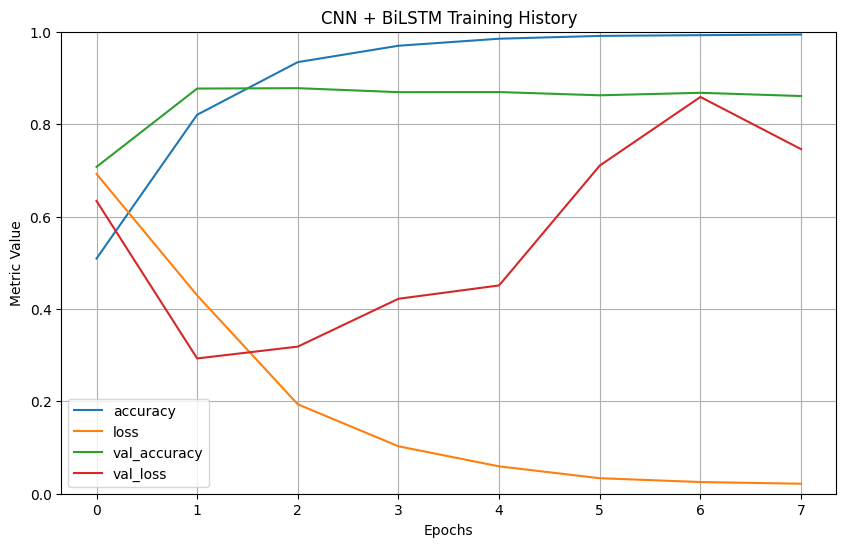

In [ ]:
# Cell 9: Model Training (Conditional: GridSearchCV or Keras fit) (MODIFIED)

print(f"\n--- Training Model: {MODEL_NAME} ---")
start_time = time.time()

best_model = None
training_history = None # To store Keras history

if IS_DEEP_LEARNING_MODEL:
    # --- Train Keras Model ---
    print("Training Keras model using model.fit()...")
    EPOCHS = 10 # Adjust as needed
    BATCH_SIZE = 64 # Adjust based on memory

    # Use EarlyStopping to prevent overfitting and save time
    early_stopping = EarlyStopping(monitor='val_accuracy', # Metric to monitor
                                   patience=5,          # Number of epochs with no improvement after which training will be stopped
                                   verbose=1,
                                   mode='max',          # Stop when the monitored quantity has stopped increasing
                                   restore_best_weights=True) # Restore model weights from the epoch with the best value

    training_history = model.fit(
        X_train_features, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_val_features, y_val),
        callbacks=[early_stopping],
        verbose=1
    )
    best_model = model # Keras model is trained in place, use the final (or restored best) model
    print("Keras model training finished.")

else:
    # --- Train Scikit-learn Model using GridSearchCV ---
    print(f"Starting GridSearchCV for {MODEL_NAME}...")
    grid_search = GridSearchCV(
        estimator=model_,        # The sklearn model instance
        param_grid=param_grid,  # The parameter grid
        cv=5,
        scoring='accuracy',
        verbose=1,
        n_jobs=-1
    )
    grid_search.fit(X_train_features, y_train) # Fit on TF-IDF features
    best_model = grid_search.best_estimator_ # Get the best estimator found
    print("GridSearchCV finished.")
    print(f"Best parameters found: {grid_search.best_params_}")
    print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")


end_time = time.time()
print(f"Training process completed in {end_time - start_time:.2f} seconds.")

if best_model is None:
    raise RuntimeError("Model training failed or did not produce a best_model.")

# Optional: Plot Keras training history if applicable
if IS_DEEP_LEARNING_MODEL and training_history:
    pd.DataFrame(training_history.history).plot(figsize=(10, 6))
    plt.grid(True)
    plt.title(f'{MODEL_NAME} Training History')
    plt.xlabel('Epochs')
    plt.ylabel('Metric Value')
    plt.gca().set_ylim(0, 1) # Set y-axis range for loss/accuracy
    plt.show()


--- Evaluating Best Model (CNN + BiLSTM) on Validation Set ---
Predicting probabilities with Keras model...
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Keras model.evaluate validation accuracy: 0.8778

--- Validation Set Performance ---
Model:      CNN + BiLSTM
Accuracy:   0.8778
Precision:  0.8617
Recall:     0.9000
F1-score:   0.8805

Validation Accuracy target (>= 80%) MET!

Validation Confusion Matrix:


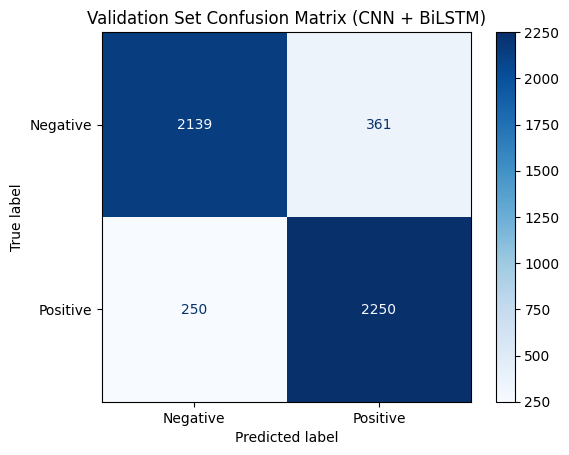

In [ ]:
# Cell 10: Evaluation on Validation Set (Conditional) (MODIFIED)

print(f"\n--- Evaluating Best Model ({MODEL_NAME}) on Validation Set ---")

y_val_pred_proba = None
y_val_pred = None

if IS_DEEP_LEARNING_MODEL:
    print("Predicting probabilities with Keras model...")
    y_val_pred_proba = best_model.predict(X_val_features)
    y_val_pred = (y_val_pred_proba > 0.5).astype(int).flatten() # Convert probabilities to 0 or 1

    # Optional: Get accuracy directly from evaluate
    loss, val_accuracy_keras = best_model.evaluate(X_val_features, y_val, verbose=0)
    print(f"Keras model.evaluate validation accuracy: {val_accuracy_keras:.4f}")

else:
    print("Predicting with scikit-learn model...")
    y_val_pred = best_model.predict(X_val_features) # Predict classes directly

# Calculate metrics using scikit-learn (works for both cases now)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)
val_cm = confusion_matrix(y_val, y_val_pred)

print("\n--- Validation Set Performance ---")
print(f"Model:      {MODEL_NAME}")
if not IS_DEEP_LEARNING_MODEL:
     print(f"Best Params:{grid_search.best_params_}") # Show params only for sklearn
print(f"Accuracy:   {val_accuracy:.4f}")
print(f"Precision:  {val_precision:.4f}")
print(f"Recall:     {val_recall:.4f}")
print(f"F1-score:   {val_f1:.4f}")

# Check goal (Context: Original goal was for non-transformers)
if val_accuracy >= 0.80:
    print("\nValidation Accuracy target (>= 80%) MET!")
else:
    print("\nValidation Accuracy target (< 80%) NOT MET.")

# Display Confusion Matrix
print("\nValidation Confusion Matrix:")
cm_display_val = ConfusionMatrixDisplay(confusion_matrix=val_cm, display_labels=['Negative', 'Positive'])
cm_display_val.plot(cmap='Blues')
plt.title(f'Validation Set Confusion Matrix ({MODEL_NAME})')
plt.show()


--- Evaluating Best Model (CNN + BiLSTM) on Test Set ---
Predicting probabilities with Keras model...
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Keras model.evaluate test accuracy: 0.8583

--- Test Set Performance ---
Model:      CNN + BiLSTM
Accuracy:   0.8583
Precision:  0.8580
Recall:     0.8587
F1-score:   0.8583

Test Confusion Matrix:


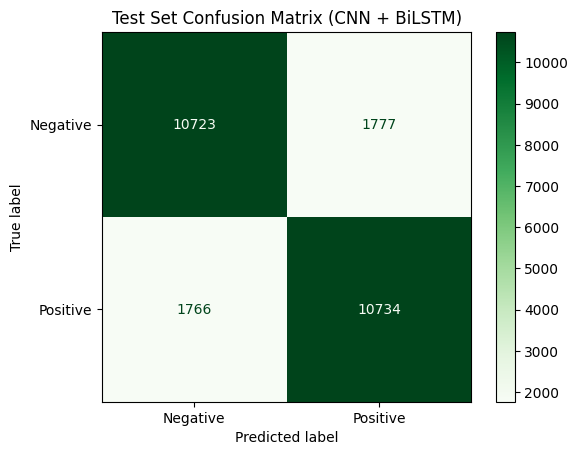


Comparison: Test Accuracy (0.8583) vs. Validation Accuracy (0.8778)


In [ ]:
# Cell 11: Evaluation on Test Set (Final Evaluation - Conditional) (MODIFIED)

print(f"\n--- Evaluating Best Model ({MODEL_NAME}) on Test Set ---")

y_test_pred_proba = None
y_test_pred = None

if IS_DEEP_LEARNING_MODEL:
    print("Predicting probabilities with Keras model...")
    y_test_pred_proba = best_model.predict(X_test_features)
    y_test_pred = (y_test_pred_proba > 0.5).astype(int).flatten() # Convert probabilities to 0 or 1

    # Optional: Get accuracy directly from evaluate
    loss_test, test_accuracy_keras = best_model.evaluate(X_test_features, y_test, verbose=0)
    print(f"Keras model.evaluate test accuracy: {test_accuracy_keras:.4f}")

else:
    print("Predicting with scikit-learn model...")
    y_test_pred = best_model.predict(X_test_features) # Predict classes directly

# Calculate metrics using scikit-learn
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_cm = confusion_matrix(y_test, y_test_pred)

print("\n--- Test Set Performance ---")
print(f"Model:      {MODEL_NAME}")
if not IS_DEEP_LEARNING_MODEL:
     print(f"Best Params:{grid_search.best_params_}") # Show params only for sklearn
print(f"Accuracy:   {test_accuracy:.4f}")
print(f"Precision:  {test_precision:.4f}")
print(f"Recall:     {test_recall:.4f}")
print(f"F1-score:   {test_f1:.4f}")

# Display Confusion Matrix
print("\nTest Confusion Matrix:")
cm_display_test = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=['Negative', 'Positive'])
cm_display_test.plot(cmap='Greens')
plt.title(f'Test Set Confusion Matrix ({MODEL_NAME})')
plt.show()

# Compare Test performance to Validation performance
print(f"\nComparison: Test Accuracy ({test_accuracy:.4f}) vs. Validation Accuracy ({val_accuracy:.4f})")
if abs(test_accuracy - val_accuracy) > 0.02:
     print("Note: Potential difference between validation and test performance observed.")


Generating side-by-side confusion matrices visualization...


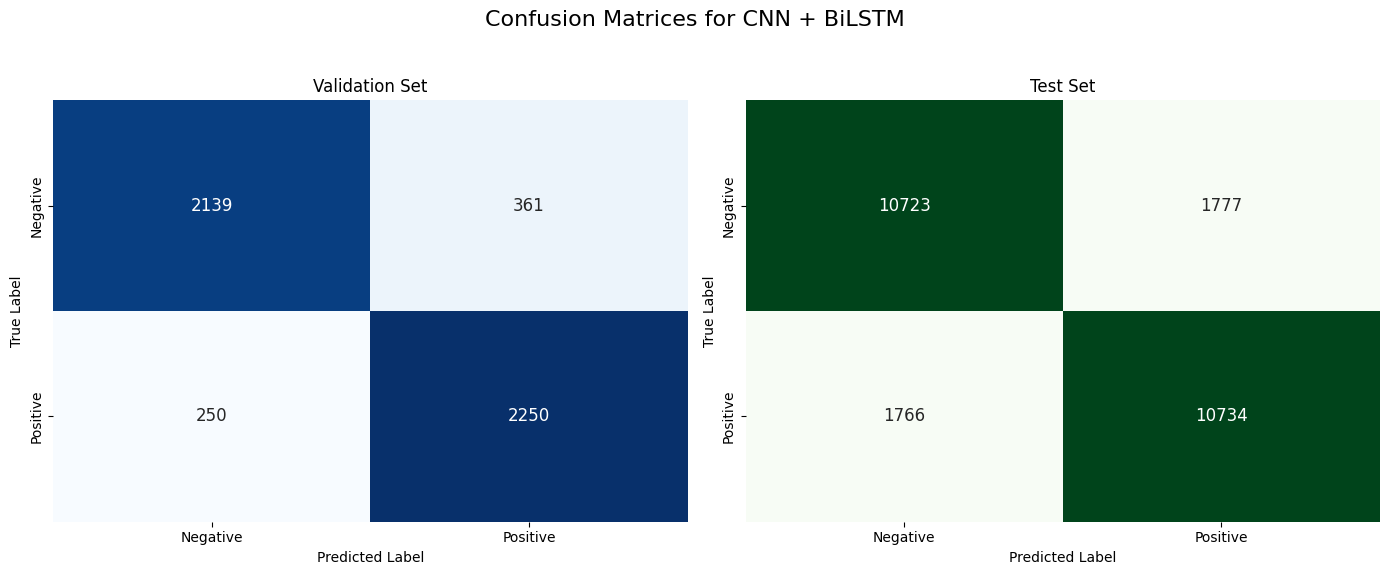

In [ ]:
# Cell 12: Visualization - Combined Confusion Matrices
# (Keep this cell as it was - it uses variables populated by Cell 10 & 11)
print("\nGenerating side-by-side confusion matrices visualization...")
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle(f'Confusion Matrices for {MODEL_NAME}', fontsize=16)
sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False, annot_kws={"size": 12})
axes[0].set_title('Validation Set')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].xaxis.set_ticklabels(['Negative', 'Positive'])
axes[0].yaxis.set_ticklabels(['Negative', 'Positive'])
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Greens', ax=axes[1], cbar=False, annot_kws={"size": 12})
axes[1].set_title('Test Set')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
axes[1].xaxis.set_ticklabels(['Negative', 'Positive'])
axes[1].yaxis.set_ticklabels(['Negative', 'Positive'])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Generating metrics comparison plot...


<Figure size 1000x600 with 0 Axes>

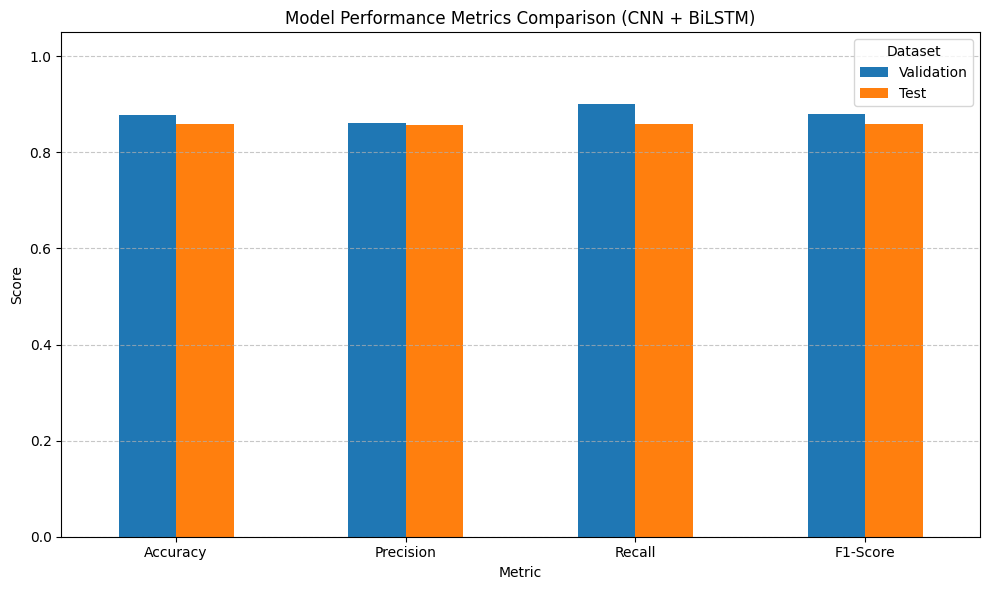


--- Experiment Complete ---


In [ ]:
# Cell 13: Visualization - Metrics Comparison Bar Chart
# (Keep this cell as it was - it uses variables populated by Cell 10 & 11)
print("\nGenerating metrics comparison plot...")
metrics_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Validation': [val_accuracy, val_precision, val_recall, val_f1],
    'Test': [test_accuracy, test_precision, test_recall, test_f1]
}
metrics_df = pd.DataFrame(metrics_data)
plt.figure(figsize=(10, 6))
metrics_df.set_index('Metric').plot(kind='bar', rot=0, figsize=(10, 6))
plt.title(f'Model Performance Metrics Comparison ({MODEL_NAME})')
plt.ylabel('Score')
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

print("\n--- Experiment Complete ---")

In [ ]:
import pickle
import json

# ... (Your existing code for model training) ...

# --- Save Models ---

if IS_DEEP_LEARNING_MODEL:
    # Save Keras model
    model.save('cnn_bilstm_model.h5')

    # Save Tokenizer
    with open('tokenizer.pkl', 'wb') as f:
        pickle.dump(tokenizer, f)

    # Save Deep Learning parameters (vocab_size, max_sequence_length, etc.)
    dl_params = {
        'vocab_size': VOCAB_SIZE,
        'max_sequence_length': MAX_SEQUENCE_LENGTH,
        'embedding_dim': EMBEDDING_DIM
    }
    with open('dl_params.json', 'w') as f:
        json.dump(dl_params, f)

else:
    # Save scikit-learn models
    model_filename = f"{MODEL_NAME.lower().replace(' ', '_')}_model.pkl"
    with open(model_filename, 'wb') as f:
        pickle.dump(best_model, f)

    # Save TF-IDF vectorizer
    with open('tfidf_vectorizer.pkl', 'wb') as f:
        pickle.dump(tfidf_vectorizer, f)

print("Models and related data saved.")

Models and related data saved.
